In [80]:
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from collections import namedtuple
import heapq
import seaborn as sns

from market import SimulationClock
from market import Exchange

In [106]:
sns.__version__

'0.7.1'

In [81]:
def bgt_scheduler( clock, FV, p_flex, lam, order_size_bound, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    quantity = np.random.randint(1,order_size_bound+1)*np.random.choice([-1,1])
    price = FV + np.random.randint(-p_flex,p_flex+1)
    heapq.heappush(event_queue,[clock.time+delta_t, price,quantity,trader,order_type])

def mm_scheduler(a1, a2, a3, b1, b2, b3, c1, c2, c3, d1, d2, d3, clock, lam, ba, bb, lastprice, depth, trader):
    order_type = 0
    delta_t = np.random.exponential(lam)
    if lastprice >= ba:
        quantity = a1*(lastprice - ba) + b1*depth
        price = c1*lastprice + d1*depth
    elif lastprice < bb:
        quantity = a2*(lastprice - bb) - b2*depth
        price = c2*lastprice + d2*depth
    else:
        quantity = 0
        price = c3*lastprice + d3*depth
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass

def mm1_scheduler(clock, e1, f1, ba, bb, trader):
    order_type = 0
    lam = e1
    delta_t = np.random.exponential(lam)
    buy_sell_sign = np.random.choice([-1,1])
    if buy_sell_sign > 0:
        price = bb
        quantity = buy_sell_sign*f1
    else:
        price = ba
        quantity = buy_sell_sign*f1
    
    heapq.heappush(event_queue,[clock.time+delta_t, price, quantity, trader, order_type])
    pass



In [115]:
generations = 50
population_size = 100
selection = 10
n_params = 2
mutation_rate = 0.5
mutation_decay = 0.9


sim_duration = 30
burn_in = 10
n_bgts = 100

# parameters 
e1 = np.random.uniform(0.5,1,population_size)
f1 = np.random.uniform(0,20,population_size)
def mutate(idx):
    if idx == 0:
        return np.random.uniform(0.5,1)
    elif idx == 1:
        return np.random.uniform(0,10)

population = list(zip(e1,f1))

for gen in range(generations): 
# simulate
    events = []
    FVs = []
    clk = SimulationClock()
    exch = Exchange(clk)
    BAs = []
    BBs = []
    t=0

    order_size_bound = 100
    FV = 100
    p_flex = 3
    p_reset = 0.01
    lam_bgt = 0.5
    lam_mm = 0.5

    event_queue = []

    #init
    for trader in range(0,n_bgts):
        bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)

    #burn_in
    while clk.time < burn_in:
        # execute next event
        event = heapq.heappop(event_queue)
        event_time, price, quantity, trader, order_type = event
        clk.time = event_time
        exch.post(price, quantity, trader, order_type)
        # reset FV
        if trader < n_bgts:
            if np.random.rand(1) < p_reset:
                FV = price
        # schedule new event
        bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)

        # stats
        events.append([clk.time,event[2],event[1]]) 
        FVs.append(FV)
        ba = exch.get_best_ask()
        bb = exch.get_best_bid()
        if ba == None:
            ba_price = FV
        else:
            ba_price = ba.price
        if bb == None:
            bb_price = FV
        else:
            bb_price = -bb.price
        BAs.append(ba_price)
        BBs.append(bb_price)

    depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]
    
    for trader in range(n_bgts,n_bgts+population_size):
        k = trader - n_bgts
        params = population[k]
        mm1_scheduler(clk, params[0], params[1], BAs[-1], BBs[-1], trader)

    while clk.time < sim_duration:
        # execute next event
        event = heapq.heappop(event_queue)
        event_time, price, quantity, trader, order_type = event
        clk.time = event_time
        exch.post(price, quantity, trader, order_type)
        # reset FV
        if trader < n_bgts:
            if np.random.rand(1) < p_reset:
                FV = price

        # stats
        events.append([clk.time,event[2],event[1]]) 
        FVs.append(FV)
        ba = exch.get_best_ask()
        bb = exch.get_best_bid()
        if ba == None:
            ba_price = FV
        else:
            ba_price = ba.price
        if bb == None:
            bb_price = FV
        else:
            bb_price = -bb.price
        BAs.append(ba_price)
        BBs.append(bb_price)

        depth = BAs[-1] - BAs[-2] - BBs[-1] + BBs[-2]

        # schedule new event
        if trader >= n_bgts:
            k = trader - n_bgts
            params = population[k]
            mm1_scheduler(clk, params[0], params[1], BAs[-1], BBs[-1], trader)        
        else:
            bgt_scheduler(clk, FV, p_flex, lam_bgt, order_size_bound, trader)
    
    # profit calculation
    trades = np.array(exch.trades)
    profit=[]
    for i in range(n_bgts,n_bgts+population_size):
        profit.append(-sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6]*trades[trades[:,4]==i][:,2]) 
                      +sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]*trades[trades[:,5]==i][:,2])
                      +(sum(trades[trades[:,4]==i][:,3]*trades[trades[:,4]==i][:,6])
                      -sum(trades[trades[:,5]==i][:,3]*trades[trades[:,5]==i][:,6]))*exch.lastprice)

# evolution
    profit = np.array(profit)
    population = np.array(population)
    top_traders = profit.argsort()[-selection:][::-1]
    #print(top_traders)
    top_profit = profit[top_traders]
    top_params = population[top_traders]
    
    print('gen',gen)
    print('mutation_rate',mutation_rate)
    print('top profit',top_profit)
    print('top parameters',top_params)
    
    new_params = []
    for i in range(top_params.shape[1]):
        new_params.append(np.random.choice(top_params[:,i],population_size))
    
    population = np.column_stack(new_params)
    for i in range(population_size):
        for j in range(len(population[i])):
            if np.random.rand(1) < mutation_rate:
                population[i][j] = mutate(j)
    population = population[:population_size]
    #population
    
    mutation_rate = mutation_rate * mutation_decay
    
    


gen 0
mutation_rate 0.5
top profit [ 472.19473419  418.28013837  412.57956043  398.49613115  398.17897641
  388.67886286  377.21883843  363.73203032  330.38849823  319.1372415 ]
top parameters [[  0.52194614  19.67478059]
 [  0.97284069  16.08769763]
 [  0.75994327  15.56169263]
 [  0.78634318  19.83266955]
 [  0.56969084  13.27263255]
 [  0.84976693  17.75503301]
 [  0.92750304  18.56750386]
 [  0.73868487  19.14379107]
 [  0.62587943  15.01765901]
 [  0.66159287  15.95686207]]
gen 1
mutation_rate 0.45
top profit [ 659.26775952  515.64940827  503.91970539  421.16340353  411.45160896
  387.1539226   285.57034731  229.79974768  224.21428865  197.69647201]
top parameters [[  0.76457442  19.67478059]
 [  0.75994327  19.83266955]
 [  0.96544298  15.95686207]
 [  0.89219676  19.14379107]
 [  0.52194614  13.27263255]
 [  0.79814122   8.6034205 ]
 [  0.84976693  15.56169263]
 [  0.52194614   8.352429  ]
 [  0.73868487   7.47380962]
 [  0.83496786  17.75503301]]
gen 2
mutation_rate 0.405
top p

gen 17
mutation_rate 0.08338590849833288
top profit [ 614.81275602  531.21907597  526.10043406  489.11140617  436.31873008
  396.84874212  396.6384907   388.14279515  376.82072143  376.82072143]
top parameters [[  0.51335415  19.83266955]
 [  0.51335415  19.67478059]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.67478059]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]]
gen 18
mutation_rate 0.0750473176484996
top profit [ 674.31076467  558.39619031  495.81673872  495.81673872  495.81673872
  456.15139963  423.91195247  416.48606053  416.48606053  416.48606053]
top parameters [[  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]]

gen 34
mutation_rate 0.01390641947218469
top profit [ 694.14343421  594.98008647  535.48207782  515.64940827  495.81673872
  456.15139963  456.15139963  456.15139963  456.15139963  451.65730966]
top parameters [[  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]]
gen 35
mutation_rate 0.012515777524966222
top profit [ 259.99203459  197.49402594  138.82868684    0.          -39.6653391
  -67.54538226  -79.3306782  -196.49402594 -198.32669549 -218.15936504]
top parameters [[  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415   2.41233508]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]
 [  0.51335415  19.83266955]

In [108]:
trades = np.array(exch.trades)
#exch.trades

In [109]:
events = np.array(events)

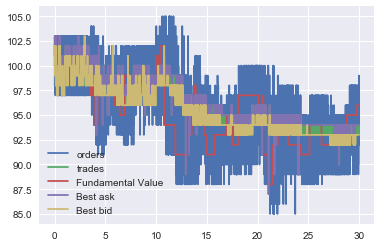

In [110]:
plt.plot(events[:,0],events[:,2], label = 'orders')
plt.plot(trades[:,0],trades[:,2], label = 'trades')
plt.plot(events[:,0],FVs, label = 'Fundamental Value')
plt.plot(events[:,0],BAs, label = 'Best ask')
plt.plot(events[:,0],BBs, label = 'Best bid')
plt.legend()

In [131]:
#list(zip(BAs,BBs))
#np.sort(np.array(exch.bids,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#np.sort(np.array(exch.asks,dtype = [('price', int), ('t', float), ('quantity', int), ('trader', int), ('order_type', int)]),order=['price','t'])
#len(events)